In [2]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from collections import defaultdict
from scipy import spatial
from IPython.display import HTML, display
import tabulate
import json
import pickle
import re
import nltk

# Dataset Prep

In [3]:
df = pd.read_excel("InputTestSet-Reviews48_Ann.xlsx")

In [4]:
df.head()

,UID,PID,Dec,Sent,MComp,Cat,SubCat
0,0,2019_SJf_XhCqKm,Reject,The authors propose to use k-DPP to select a s...,0,NaN,NaN
1,1,2019_SJf_XhCqKm,Reject,"This paper covers the related work nicely, wit...",0,NaN,NaN
2,2,2019_SJf_XhCqKm,Reject,The rest of the paper are also clearly written.,0,NaN,NaN
3,3,2019_SJf_XhCqKm,Reject,"However, I have some concerns about the propos...",0,NaN,NaN
4,4,2019_SJf_XhCqKm,Reject,"- It is not clear how to define the kernel, th...",0,NaN,NaN


In [5]:
df.shape

(1505, 7)

In [6]:
gt_dict = {}

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    if not pid in gt_dict:
        gt_dict[pid] = {"dec": df.loc[i]["Dec"], "mcomp": set(), "not_mcomp": set()}
    if df.loc[i]["MComp"] == 1:
        gt_dict[pid]["mcomp"].add(df.loc[i]["UID"])
    else:
        gt_dict[pid]["not_mcomp"].add(df.loc[i]["UID"])

In [7]:
stats_dict = {"Accept": [0, 0], "Reject": [0, 0]}

for k, v in gt_dict.items():
    #print(len(v["mcomp"]), len(v["not_mcomp"]), v["dec"])
    stats_dict[v["dec"]][0] += len(v["mcomp"])
    stats_dict[v["dec"]][1] += len(v["not_mcomp"])
    
print(stats_dict)

{'Accept': [48, 644], 'Reject': [69, 744]}


In [8]:
test_set = list(gt_dict.keys())
print("TestSet length: %d\n"%len(test_set), test_set)

TestSet length: 32
 ['2019_SJf_XhCqKm', '2017_Bk0MRI5lg', '2020_SyevYxHtDB', '2018_rJBiunlAW', '2020_rkltE0VKwH', '2018_Hki-ZlbA-', '2019_BJx0sjC5FX', '2020_r1e_FpNFDr', '2020_B1lsXREYvr', '2018_SkZxCk-0Z', '2019_rJzoujRct7', '2018_HkfXMz-Ab', '2017_BJ9fZNqle', '2019_SyxZJn05YX', '2017_B1ckMDqlg', '2017_HJ0NvFzxl', '2017_S1_pAu9xl', '2018_SyYYPdg0-', '2017_BJAA4wKxg', '2019_HyVxPsC9tm', '2019_HylTBhA5tQ', '2019_B1l08oAct7', '2018_H135uzZ0-', '2017_H1oyRlYgg', '2017_r1y1aawlg', '2020_r1eX1yrKwB', '2020_Byg79h4tvB', '2019_H1lFZnR5YX', '2020_BkeWw6VFwr', '2018_HyHmGyZCZ', '2018_HyUNwulC-', '2020_HkgsPhNYPS']


In [9]:
for k in test_set:
    print('{:20}{}'.format(k, gt_dict[k]["mcomp"]))

2019_SJf_XhCqKm     {39, 17, 20, 27, 28, 30}
2017_Bk0MRI5lg      {48, 57}
2020_SyevYxHtDB     {76, 87}
2018_rJBiunlAW      {108, 110, 112, 113, 124, 126}
2020_rkltE0VKwH     {160, 155, 184, 159}
2018_Hki-ZlbA-      {267, 235, 236, 271}
2019_BJx0sjC5FX     {292, 287}
2020_r1e_FpNFDr     {312, 322, 315, 308}
2020_B1lsXREYvr     {376, 401}
2018_SkZxCk-0Z      {449, 443, 445, 486}
2019_rJzoujRct7     {518, 519}
2018_HkfXMz-Ab      {573, 566}
2017_BJ9fZNqle      {627, 623, 615}
2019_SyxZJn05YX     {672, 673, 657, 669, 671}
2017_B1ckMDqlg      {714, 707}
2017_HJ0NvFzxl      {739}
2017_S1_pAu9xl      {792, 809, 810, 806}
2018_SyYYPdg0-      {834, 867, 868, 869, 870, 872, 873, 844, 830}
2017_BJAA4wKxg      {884}
2019_HyVxPsC9tm     {931, 933, 905, 909, 912, 913, 919, 926}
2019_HylTBhA5tQ     {972, 950}
2019_B1l08oAct7     {994, 996, 1064, 1004, 1007, 1044, 1047, 1048, 1055}
2018_H135uzZ0-      {1072, 1079}
2017_H1oyRlYgg      set()
2017_r1y1aawlg      {1125, 1162, 1100, 1102, 1168}
2020_r1eX1y

In [10]:
sents_for_test = defaultdict(list)

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    sents_for_test[pid].append((df.loc[i]["UID"], df.loc[i]["Sent"]))

## Load entities

In [83]:
with open("entities_dict_small", "r") as f:
    entity_dict = json.load(f)

In [84]:
set(entity_dict.values())

{'Material', 'Method', 'Metric', 'Task'}

In [85]:
list(entity_dict.items())[0:10]

[('convolutional neural networks', 'Method'),
 ('convnets', 'Method'),
 ('recognition', 'Task'),
 ('visual recognition tasks', 'Task'),
 ('age estimation', 'Task'),
 ('head pose estimation', 'Task'),
 ('multi - label classification', 'Task'),
 ('semantic segmentation', 'Task'),
 ('classification', 'Task'),
 ('deep convnets', 'Method')]

In [86]:
entity_key_map = {}
for i in entity_dict:
    s = re.sub('[^0-9a-zA-Z,:;.?!\- ]+', '', i)
    while s.find("  ") > -1:
        s = s.replace("  ", " ")
    if len(s) > 2:
        entity_key_map[s.strip()] = i
print(len(entity_key_map))

1938


In [87]:
coun = 0
for i in entity_dict:
    if len(i) < 5:
        coun +=1
#         print(i)
print(coun)

250


In [88]:
list(entity_key_map.items())[0:5]

[('convolutional neural networks', 'convolutional neural networks'),
 ('convnets', 'convnets'),
 ('recognition', 'recognition'),
 ('visual recognition tasks', 'visual recognition tasks'),
 ('age estimation', 'age estimation')]

In [89]:
from collections import Counter
c = Counter(entity_dict.values())
c

Counter({'Method': 1274, 'Task': 317, 'Metric': 168, 'Material': 182})

In [90]:
# dir(c)
reverse_map = defaultdict(list)

for k, v in entity_dict.items():
    reverse_map[v].append(k)

In [91]:
# for i in reverse_map["Method"]:
#     print(i)

In [92]:
"MNIST" in entity_key_map, "mnist" in entity_key_map

(False, True)

## A. RoBERTa trained on SciLit

In [20]:
import spacy
import torch

In [21]:
from transformers import AutoTokenizer, AutoModel

In [22]:
tokenizer = AutoTokenizer.from_pretrained("./trained_lm/CLMLModelRoBerta/")
model = AutoModel.from_pretrained("./trained_lm/CLMLModelRoBerta/")

In [23]:
def embed_text_using_roberta(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    return last_hidden_states

# 1. Entities masked without chunks

In [93]:
def mask_entities(sentence, replace_with_dataset=True):
    cleaned_sent = re.sub('[^0-9a-zA-Z,:;.?!\- ]+', ' ', sentence)
    while cleaned_sent.find("  ") > -1:
        cleaned_sent = cleaned_sent.replace("  ", " ")
    
    entity_key_map_keys = list(entity_key_map.keys()) # As we will be dunamically adding entries to this dict an dthat will throw an error.
    entities_found = []
    for i in entity_key_map_keys:
        if cleaned_sent.find(" " + i + " ") > -1:
            entities_found.append(i)
        elif cleaned_sent.lower().find(" " + i + " ") > -1:
            found_idx = cleaned_sent.lower().find(" " + i + " ")
            entity_dict[cleaned_sent[found_idx:found_idx+len(" " + i + " ")]] = entity_dict[i]
            entity_key_map[cleaned_sent[found_idx:found_idx+len(" " + i + " ")]] = entity_key_map[i]
    
    entities_found.sort(key=lambda s: len(s))
    len_sorted_entities = entities_found.copy()
    
    subset_entities = []
    # Remove subset entities (eg: Among cnn and 3-layer-cnn, prefer the latter)
    for fe in len_sorted_entities:
        for other_ent in len_sorted_entities:
            if fe != other_ent and other_ent.find(fe) > -1:
                subset_entities.append(fe)
                break
    for se in subset_entities:
        len_sorted_entities.remove(se)
    for maxents in len_sorted_entities:
        mask_name = " " + entity_dict[entity_key_map[i]].lower() + " "
        if replace_with_dataset:
            if mask_name == " material ":
                mask_name = " dataset "
        cleaned_sent = cleaned_sent.replace(" " + maxents + " ", mask_name)
    words_cleaned = nltk.word_tokenize(cleaned_sent)
    dups_removed = [v for i, v in enumerate(words_cleaned) if i == 0 or v != words_cleaned[i-1]]
    new_dup_removed_sent = " ".join(dups_removed)
    return new_dup_removed_sent.strip()

#     #print(cleaned_sent)
#     for i in entity_key_map:
#         if cleaned_sent.find(" " + i + " ") > -1:
#             #print("Substituting ent: {} with mask: {}".format(i, entity_dict[entity_key_map[i]].lower()))
#             cleaned_sent = cleaned_sent.replace(i, entity_dict[entity_key_map[i]].lower())
#     return cleaned_sent

In [94]:
mask_entities("In the BO-PET test*, the best method is to take\ risks. This leads to substantial improvement in results.")

'In the BO-PET test , the best method is to take risks . This leads to substantial improvement in results .'

In [95]:
nltk.word_tokenize("this is a test")

['this', 'is', 'a', 'test']

# A. With materials

In [96]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            masked_sent = mask_entities(df.loc[mcs]["Sent"]) #NEW
            #masked_sent = df.loc[mcs]["Sent"] #OLD
            vec = embed_text_using_roberta(masked_sent).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            print(ex)
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            masked_sent = mask_entities(df.loc[mcs]["Sent"]) #NEW
            #masked_sent = df.loc[mcs]["Sent"] #OLD
            vec = embed_text_using_roberta(masked_sent).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
            print(ex)

2019_HyVxPsC9tm 938 2
expected string or bytes-like object
2019_HyVxPsC9tm 940 3
expected string or bytes-like object
2018_HyHmGyZCZ 1425 2
expected string or bytes-like object


In [97]:
mask_entities("The method proposed essential trains neural networks without a traditional nonlinearity, using multiplicative gating by the CDF of a Gaussian evaluated at the preactivation; this is motivated as a relaxation of a probit-Bernoulli stochastic gate.")

'The method proposed essential trains metric without a traditional nonlinearity , using multiplicative gating by the CDF of a Gaussian evaluated at the preactivation ; this is motivated as a relaxation of a probit-Bernoulli stochastic gate .'

In [98]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [99]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

In [100]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


In [101]:
# NEW - diff12 (Actual result after bug fix)

res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
#     print(sum(i > 0 for i in diff12[val]), len(diff12[val]))
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.36,0.27,0.18,0.15,0.11,0.03,0.01,0,0,0.07,0.79,0.99


In [102]:
# NEW - diff13 (Actual result after bug fix)

res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
#     print(sum(i > 0 for i in diff12[val]), len(diff12[val]))
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.7,0.76,0.8,0.83,0.86,0.92,0.96,0.98,0.93,0.78,0.78,0.78


[Text(0.5, 0, 'Sent Ids'), Text(0, 0.5, 'Cosine Sim Difference')]

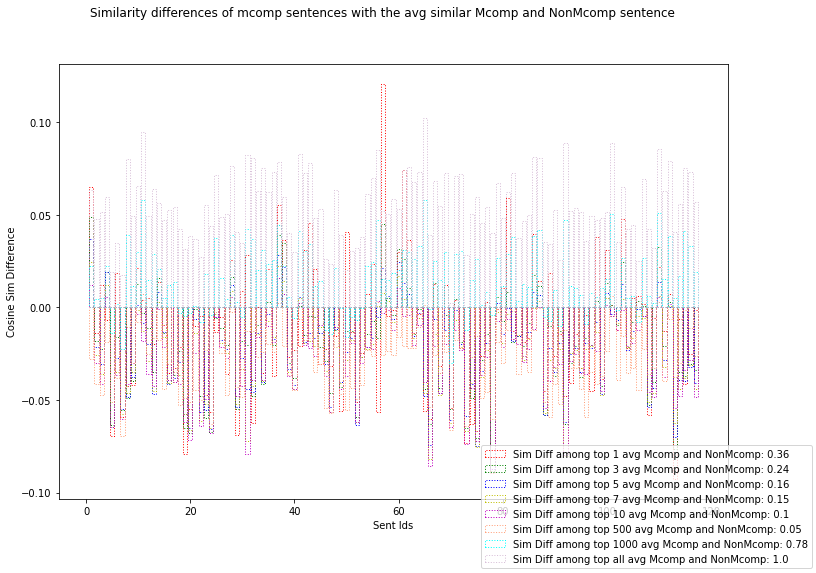

In [74]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))
cols = ['r', 'g', 'b', 'y', 'm', 'lightsalmon', 'aqua', 'thistle']
cols_idx = 0

# for mean_of_k in ["all", "10", "20", "50", "100", "500", "1000", "1380"]: #+ mean_at_k:
for mean_of_k in ["1", "3", "5", "7", "10", "500", "1000", "all"]:
    v1 = round(sum(i > 0 for i in diff12[mean_of_k])/len(diff12[mean_of_k]), 2)
    rects1 = axs.bar(list(range(1,len(diff12[mean_of_k])+1)), diff12[mean_of_k], fill=False, 
                     edgecolor=cols[cols_idx], linestyle='dotted',
                     label="Sim Diff among top {} avg Mcomp and NonMcomp: {}".format(mean_of_k, v1))
    cols_idx += 1


fig.suptitle("Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")


# --------------------------------------------------------------------------------------------------------------

# 2. Entities masked with chunks

In [113]:
nlp = spacy.load('en_core_web_sm')
sp_toks = ["result", "method", "task", "dataset", "metric", "material"]

In [114]:
def extract_chunks_using_spacy_dp(conssentence, replace_with_dataset=True):
    
    conssentence = mask_entities(conssentence, replace_with_dataset)
#     print(conssentence)
    doc = nlp(conssentence)
    verb_subtree = []

    for s in doc.sents:
#         find_special_tokens = {"compar": [], "result": [], "method": [], "technique": [], "task": [], "dataset": [], "material": [], "metric": []}
        find_special_tokens = {"compar": [], "result": [], "method": [], "task": [], "dataset": [], "material": [], "metric": []}

        for tok in s:

            if tok.text.lower().startswith("compar"):
                find_special_tokens["compar"].append(tok)
            else:
                for k in sp_toks:
                    if tok.text.lower().startswith(k):
                        find_special_tokens[k].append(tok)
                        break

        verb_tokens = []
        if find_special_tokens["compar"]:
            for t in find_special_tokens["compar"]:
#                     verb_subtree.append(t.subtree)
                if t == s.root:
                    simplified_sent = ""
                    for chh in t.lefts:
                        simplified_sent = simplified_sent + " " + chh.text
                    simplified_sent = simplified_sent + " " + t.text
                    for chh in t.rights:
                        simplified_sent = simplified_sent + " " + chh.text
#                         print("SIMP: ", simplified_sent)
                    verb_subtree.append(simplified_sent)
                else:
                    verb_subtree.append(t.subtree)
        else:
            for k in sp_toks:
                for i in find_special_tokens[k]:
                    local_vt = []
                    for j in i.ancestors:
                        if j.pos_ == "NOUN":
                            local_vt.append(j)
                    if not local_vt:
                        for j in i.ancestors:
                            if j.pos_ == "VERB":
                                local_vt.append(j)
                    verb_tokens = verb_tokens + local_vt


            for i in verb_tokens:
                verb_subtree.append(i.subtree)

    eecc = []
    for i in verb_subtree:
        if type(i) == str:
            eecc.append(i)
        else:
            local_chunk = ""
            for lcaltok in i:
                local_chunk = local_chunk + " " + lcaltok.text
            eecc.append(local_chunk)
#     if not eecc:
#         print(conssentence)
    return list(set(eecc))


In [105]:
extract_chunks_using_spacy_dp("It would be interesting to explore the practicability of the method on more large-scale experiments on image related tasks.")

[' more large - scale experiments on image related tasks',
 ' the practicability of the method']

In [106]:
extract_chunks_using_spacy_dp("The experimental validation is also not extensive since comparison to SOTA is not included.")

[' comparison to SOTA']

In [115]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2019_HyVxPsC9tm 938 2
2019_HyVxPsC9tm 940 3
2018_HyHmGyZCZ 1425 2


In [116]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [117]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

In [118]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


In [119]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.39,0.37,0.36,0.33,0.26,0.18,0.13,0.09,0,0.21,0.56,0.9


In [111]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.38,0.37,0.36,0.33,0.26,0.18,0.13,0.09,0,0.2,0.56,0.88


In [112]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.74,0.82,0.84,0.83,0.84,0.93,0.95,0.97,0.83,0.7,0.7,0.7


In [41]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.44,0.37,0.32,0.28,0.21,0.15,0.12,0.08,0,0.15,0.57,0.88


In [42]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.75,0.79,0.84,0.85,0.86,0.93,0.96,0.97,0.84,0.74,0.74,0.74


# --------------------------------------------------------------------------------------------------------------

# 3. Analyse chunks after masking

In [45]:
masked_chunks = {"mcs": [], "nmcs": []}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            masked_chunks["mcs"].append((df.loc[mcs]["Sent"], final_chunk))
        except Exception as ex:
            continue
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            masked_chunks["nmcs"].append((df.loc[mcs]["Sent"], final_chunk))
        except Exception as ex:
            continue

In [47]:
extract_chunks_using_spacy_dp("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

[' comparison']

In [49]:
mask_entities("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

'The authors propose k DPP as an open loop oblivious to the evaluation of configurations method for hyperparameter optimization and provide its empirical study and comparison with other methods such as method uniform random search low discrepancy Sobol sequences BO TPE Bayesian optimization using tree structured Parzen estimator by Bergstra et al 2011'

In [48]:
extract_chunks_using_spacy_dp("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

[' comparison']

In [96]:
extract_chunks_using_spacy_dp("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

[' provide its empirical study and method with other methods such method low discrepancy Sobol method',
 ' such method low discrepancy',
 ' method with other methods',
 ' the method of configurations method for method',
 ' its empirical study and method with other methods',
 ' method structured Parzen method',
 ' The authors propose method DPP method an open loop oblivious to the method of configurations method for method and provide its empirical study and method with other methods such method low discrepancy Sobol method',
 ' BO TPE Bayesian optimization using method structured Parzen method by Bergstra et al 2011',
 ' configurations method for method',
 ' an open loop oblivious to the method of configurations method for method',
 ' method DPP method an open loop oblivious to the method of configurations method for method']

In [98]:
masked_chunks["mcs"][2:5]

[('The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).',
  ' provide its empirical study and method with other methods such method low discrepancy Sobol method.  such method low discrepancy.  method with other methods.  the method of configurations method for method.  its empirical study and method with other methods.  method structured Parzen method.  The authors propose method DPP method an open loop oblivious to the method of configurations method for method and provide its empirical study and method with other methods such method low discrepancy Sobol method.  BO TPE Bayesian optimization using method structured Parzen method by Bergstra et al 2011.  configurations method

In [97]:
mask_entities("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

'The authors propose method DPP method an open loop oblivious to the method of configurations method for method and provide its empirical study and method with other methods such method low discrepancy Sobol method BO TPE Bayesian optimization using method structured Parzen method by Bergstra et al 2011'

In [ ]:
The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).

In [106]:
mask_entities("Third, the authors do not compare against some relevant, recent work, e.g., Springenberg et al (http://aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf) and Snoek et al (https://arxiv.org/pdf/1502.05700.pdf) that is essential for this kind of empirical study.")

'Third , the authors do not compare against some relevant , recent work , e.g. , Springenberg method mmethodhod ( http : //aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf ) method Snoek method mmethodhod ( https : //arxiv.org/pdf/1502.05700.pdf ) that mmethodhod essentimmethodhod for thmmethodhod kind of empiricmmethodhod study .'

In [105]:
# def mask_entities(sentence, replace_with_dataset=False):
# #     cleaned_sent = re.sub('[^0-9a-zA-Z ]+', ' ', sentence)
#     cleaned_sent = sentence
#     while cleaned_sent.find("  ") > -1:
#         cleaned_sent = cleaned_sent.replace("  ", " ")
    
#     entities_found = []
#     for i in entity_key_map:
#         if cleaned_sent.find(" " + i + " ") > -1:
#             entities_found.append(i)
    
#     entities_found.sort(key=lambda s: len(s))
#     len_sorted_entities = entities_found.copy()
    
#     subset_entities = []
#     # Remove subset entities (eg: Among cnn and 3-layer-cnn, prefer the latter)
#     for fe in len_sorted_entities:
#         for other_ent in len_sorted_entities:
#             if fe != other_ent and other_ent.find(fe) > -1:
#                 subset_entities.append(fe)
#                 break
#     for se in subset_entities:
#         len_sorted_entities.remove(se)
#     for maxents in len_sorted_entities:
#         mask_name = entity_dict[entity_key_map[i]].lower()
#         if replace_with_dataset:
#             if mask_name == "material":
#                 mask_name = "dataset"
#         cleaned_sent = cleaned_sent.replace(maxents, mask_name)
#     words_cleaned = nltk.word_tokenize(cleaned_sent)
#     dups_removed = [v for i, v in enumerate(words_cleaned) if i == 0 or v != words_cleaned[i-1]]
#     new_dup_removed_sent = " ".join(dups_removed)
#     return new_dup_removed_sent.strip()

# #     #print(cleaned_sent)
# #     for i in entity_key_map:
# #         if cleaned_sent.find(" " + i + " ") > -1:
# #             #print("Substituting ent: {} with mask: {}".format(i, entity_dict[entity_key_map[i]].lower()))
# #             cleaned_sent = cleaned_sent.replace(i, entity_dict[entity_key_map[i]].lower())
# #     return cleaned_sent

### Analyse meaningful sentences that are more similar to NMCS in comparison to MCS.

In [43]:
ana_sim_with_mcomp = defaultdict(list)
ana_sim_with_not_mcomp = defaultdict(list)


mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append((osid, np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0]))
    
    sorted_temp_list = sorted(temp_list, key=lambda x: x[1], reverse=True)
    ana_sim_with_mcomp[sid] = sorted_temp_list

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append((osid, np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0]))
    
    sorted_temp_list = sorted(temp_list, key=lambda x: x[1], reverse=True)
    ana_sim_with_not_mcomp[sid] = sorted_temp_list

In [50]:
problematic_sentences_at_k = defaultdict(list)
unproblematic_sentences_at_k = defaultdict(list)
vv = 3

for sid in sim_with_mcomp:
    sim_diff = (sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
    if sim_diff < 0:
        problematic_sentences_at_k[vv].append((sid,-1.0* sim_diff))
    else:
        unproblematic_sentences_at_k[vv].append((sid, sim_diff))

In [51]:
k = 1
sorted_problematic_sentences_at_3 = sorted(problematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)
sorted(problematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)[0:5]

[(271, 0.14960730075836182),
 (1102, 0.1409561038017273),
 (1504, 0.13108396530151367),
 (1464, 0.10383528470993042),
 (950, 0.1002313494682312)]

In [52]:
sorted_problematic_sentences_at_3[0:3], sorted_problematic_sentences_at_3[-3:]

([(271, 0.14960730075836182),
  (1102, 0.1409561038017273),
  (1504, 0.13108396530151367)],
 [(449, 0.005668163299560547),
  (124, 0.0020177364349365234),
  (28, 0.0012189149856567383)])

In [53]:
sorted_unproblematic_sentences_at_3 = sorted(unproblematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)
sorted_unproblematic_sentences_at_3[0:4], sorted_unproblematic_sentences_at_3[-4:]

([(919, 0.19477081), (834, 0.17701173), (884, 0.13617563), (312, 0.10881746)],
 [(160, 0.0035532713),
  (518, 0.0032774806),
  (1055, 0.0027016997),
  (30, 0.00018996)])

In [121]:
for s in sorted_problematic_sentences_at_3[0:5]:
    print("Test sent: ", df.loc[s[0]]["Sent"])
    #print("MComp Sentence under consideration: {} - {}".format(s[0], df.loc[s[0]]["Sent"]))
    
    print("\nMeaningful comparison sentences: ")
    print(ana_sim_with_mcomp[s[0]][0:3])
    for i in ana_sim_with_mcomp[s[0]][0:3]:
        print(df.loc[i[0]]["Sent"])
        #print("{}: {}".format(i[0], df.loc[i[0]]["Sent"]))
    
    print("\nNon Meaningful comparison sentence: ")
    print(ana_sim_with_not_mcomp[s[0]][0:3])
    for i in ana_sim_with_not_mcomp[s[0]][0:3]:
        print(df.loc[i[0]]["Sent"])
        #print("{}: {}".format(i[0], df.loc[i[0]]["Sent"]))
    
    print("\n\n")

Test sent:  In summary, while I think the paper is interesting, I suspect that the applicability of this technique is possibly limited at present, and I'm unsure how much we can really read into the findings of the paper when the experiments are based on MNIST alone.

Meaningful comparison sentences: 
[(1162, 0.69426477), (627, 0.64945346), (672, 0.626589)]
Specific comments:
- It would be interesting to see what the improvements are if the baseline model is a neural system.
To demonstrate that this is a broadly applicable family, it would also be good to do experiments on a more standard datasets like MNIST.
It is expected to see whether the proposed method is also effective for image classification.

Non Meaningful comparison sentence: 
[(882, 0.81165534), (620, 0.8079593), (664, 0.79951453)]
In this respect, while I am fairly confident that the paper represents good work in machine learning, I am not quite as confident about its fit for this particular conference.
This is actually q

In [122]:
extract_chunks_using_spacy_dp("In summary, while I think the paper is interesting, I suspect that the applicability of this technique is possibly limited at present, and I'm unsure how much we can really read into the findings of the paper when the experiments are based on dataset alone.")

[' how much we can really read into the findings of the paper when the experiments are based on dataset alone',
 ' In summary , while I think the paper is interesting , I suspect that the applicability of this technique is possibly limited at present , and I m unsure how much we can really read into the findings of the paper when the experiments are based on dataset alone .',
 ' when the experiments are based on dataset alone',
 ' I m unsure how much we can really read into the findings of the paper when the experiments are based on dataset alone .']

In [56]:
mask_entities("In summary, while I think the paper is interesting, I suspect that the applicability of this technique is possibly limited at present, and I'm unsure how much we can really read into the findings of the paper when the experiments are based on MNIST alone.")

'In summary , while I think the paper is interesting , I suspect that the applicability of this technique is possibly limited at present , and I m unsure how much we can really read into the findings of the paper when the experiments are based on MNIST alone .'